# Setup

In [1]:
!pip install opendatasets -q

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data Loading

In [4]:
od.download("https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database")

100%|██████████| 25.0M/25.0M [00:00<00:00, 72.3MB/s]


In [5]:
anime = pd.read_csv("/content/anime-recommendations-database/anime.csv")
rating = pd.read_csv("/content/anime-recommendations-database/rating.csv")

In [6]:
print("Total # of samples in anime dataframe: ", len(anime.anime_id.unique()))
print("Total # of samples in rating dataframe: ", len(rating))

Total # of samples in anime dataframe:  12294
Total # of samples in rating dataframe:  7813737


# Data Understanding
- dataset link: [click here!](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

## EDA - Variable Description

- anime.csv:
  - anime_id: myanimelist.net's unique id identifying an anime.
  - name: full name of anime.
  - genre: comma separated list of genres for this anime.
  - type: type of the anime. movie, TV, OVA, etc.
  - episodes: number of episodes. (1 if movie).
  - rating: average rating out of 10 for this anime.
  - members: number of community members that are in this anime's
"group".
- rating.csv
  - user_id: randomly generated user_id
  - anime_id:  the anime that this user has rated.
  - rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

## DataFrame Anime

In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


As shown below, the genres in the 'genre' column are in comma-separated values format. This needs to be changed so that the machine can identify the genre of each anime.

The dataset is not clean, so it will be difficult to identify each genre available in the dataset. This will be explained in the **Data Preparation** section.

In [9]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [10]:
print(anime.shape)

(12294, 7)


## DataFrame Rating

In [8]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Rating dataframe has a lot of samples. This can be computationally expensive to train, to simplify this project the size will be reduced.

In [11]:
print(rating.shape)

(7813737, 3)


In [12]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [13]:
print("Lowest rating: ", min(rating.rating))
print("Biggest rating: ", max(rating.rating))

Lowest rating:  -1
Biggest rating:  10


Total # of user:  73515
Total # of anime:  11200


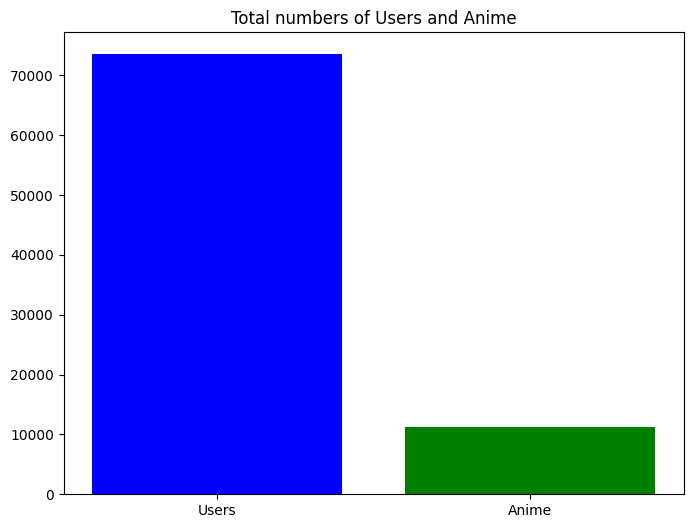

In [14]:
num_users = len(rating.user_id.unique())
num_anime = len(rating.anime_id.unique())

print("Total # of user: ", num_users)
print("Total # of anime: ", num_anime)

plt.figure(figsize=(8, 6))
plt.bar(['Users', 'Anime'], [num_users, num_anime], color=['blue', 'green'])
plt.title("Total numbers of Users and Anime")
plt.show()

# Data Preparation

## Anime Data Preparation

### Convert genre from each anime to list

In [15]:
anime['genre'] = anime['genre'].str.split(', ')

In [16]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266


### Handle missing values for anime dataframe

In [17]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [18]:
anime_clean = anime.dropna()

In [19]:
anime_clean.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Check unique genres

In [20]:
genre_flatten = [genre for sublist in anime_clean['genre'] for genre in sublist]

unique_genres = pd.Series(genre_flatten).unique()
print("Total # of genre: ", len(unique_genres))
print("List of all genre availabel: ", unique_genres)

Total # of genre:  43
List of all genre availabel:  ['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'Super Power' 'Space' 'Slice of Life'
 'Mecha' 'Music' 'Mystery' 'Seinen' 'Martial Arts' 'Vampire' 'Shoujo'
 'Horror' 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'Shounen Ai'
 'Game' 'Dementia' 'Harem' 'Cars' 'Kids' 'Shoujo Ai' 'Hentai' 'Yaoi'
 'Yuri']


### Drop unused columns

In [21]:
anime_new = anime_clean[['anime_id', 'name', 'genre']]
anime_new

,anime_id,name,genre
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ..."
...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,[Hentai]
12290,5543,Under World,[Hentai]
12291,5621,Violence Gekiga David no Hoshi,[Hentai]
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,[Hentai]


### Drop rows with "R-rated" genres
- the "R-rated" genres i decided to drop is:
  - Yaoi
  - Yuri
  - Hentai
  - Shounen Ai
  - Shoujo Ai

In [22]:
r_rated_genres = ['Yaoi', 'Yuri', 'Hentai', 'Shounen Ai', 'Shoujo Ai']

mask = anime_new['genre'].apply(lambda x: any(genre in x for genre in r_rated_genres))

anime_final = anime_new[~mask]
anime_final

,anime_id,name,genre
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ..."
...,...,...,...
10891,11095,Zouressha ga Yatte Kita,[Adventure]
10892,7808,Zukkoke Knight: Don De La Mancha,"[Adventure, Comedy, Historical, Romance]"
10893,28543,Zukkoke Sannin-gumi no Hi Asobi Boushi Daisakusen,"[Drama, Kids]"
10894,18967,Zukkoke Sannin-gumi: Zukkoke Jikuu Bouken,"[Comedy, Historical, Sci-Fi]"


### Convert genre list to string
separates the genre list from each rows with space, and preventing the genre's with space from being separated

In [23]:
anime_final['genre_str'] = anime_final['genre'].apply(lambda x: ' '.join(g.replace(' ', '') for g in x))
anime_final

<ipython-input-23-c4e0b40f75e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_final['genre_str'] = anime_final['genre'].apply(lambda x: ' '.join(g.replace(' ', '') for g in x))


,anime_id,name,genre,genre_str
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Drama Romance School Supernatural
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",Action Adventure Drama Fantasy Magic Military ...
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",Action Comedy Historical Parody Samurai Sci-Fi...
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",Sci-Fi Thriller
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",Action Comedy Historical Parody Samurai Sci-Fi...
...,...,...,...,...
10891,11095,Zouressha ga Yatte Kita,[Adventure],Adventure
10892,7808,Zukkoke Knight: Don De La Mancha,"[Adventure, Comedy, Historical, Romance]",Adventure Comedy Historical Romance
10893,28543,Zukkoke Sannin-gumi no Hi Asobi Boushi Daisakusen,"[Drama, Kids]",Drama Kids
10894,18967,Zukkoke Sannin-gumi: Zukkoke Jikuu Bouken,"[Comedy, Historical, Sci-Fi]",Comedy Historical Sci-Fi


## Rating Data Preparation

### Reduce the size of rating dataframe

In [24]:
rating = rating[:100000]
print("The size of rating dataset: ", len(rating))
rating

The size of rating dataset:  100000


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
99995,1028,5507,-1
99996,1028,5678,8
99997,1028,5680,8
99998,1028,5681,10


In [25]:
num_users = len(rating.user_id.unique())
num_anime = len(rating.anime_id.unique())

print("Total # of users after reduction: ", num_users)
print("Total # of anime after reduction: ", num_anime)

Total # of users after reduction:  1028
Total # of anime after reduction:  5154


In [26]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Encode the user id and anime id

In [27]:
user_ids = rating['user_id'].unique().tolist()
print("List user_id: ", user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print("Encoded user_id: ", user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print("Decoded user_id: ", user_encoded_to_user)

List user_id:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [28]:
anime_ids = rating['anime_id'].unique().tolist()
print("List anime_id: ", anime_ids)

anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
print("Encoded anime_id: ", anime_to_anime_encoded)

anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
print("Decoded anime_id: ", anime_encoded_to_anime)

List anime_id:  [20, 24, 79, 226, 241, 355, 356, 442, 487, 846, 936, 1546, 1692, 1836, 2001, 2025, 2144, 2787, 2993, 3455, 4063, 4214, 4224, 4581, 4744, 4898, 4999, 5034, 5277, 5667, 5781, 5958, 6163, 6205, 6324, 6500, 6547, 6682, 6707, 6747, 6773, 6793, 7088, 7148, 7593, 7739, 7858, 8074, 8407, 8424, 8525, 8630, 8841, 9041, 9062, 9136, 9181, 9330, 9367, 9515, 9581, 9675, 9750, 9790, 9919, 10067, 10073, 10076, 10079, 10080, 10209, 10578, 10604, 10719, 10790, 10793, 10794, 10805, 10897, 11161, 11266, 11617, 11737, 11757, 11759, 11771, 12293, 12549, 12729, 13357, 13367, 13411, 13561, 13663, 13759, 14749, 14813, 14833, 14967, 15117, 15437, 15451, 15583, 15609, 16011, 16498, 16706, 17265, 17729, 18247, 18277, 18753, 18897, 19163, 19221, 19285, 19429, 19815, 20045, 20785, 20787, 21033, 21881, 22147, 22199, 22319, 22535, 22547, 22663, 22877, 23233, 23321, 23847, 24133, 24455, 24873, 25099, 25157, 25159, 25283, 25397, 26243, 27775, 27899, 28121, 28677, 29093, 29095, 30015, 30296, 30544, 31338

In [29]:
# Map the encoded user_id and anime_id into new columns
rating['user'] = rating['user_id'].map(user_to_user_encoded)
rating['anime'] = rating['anime_id'].map(anime_to_anime_encoded)

### Change -1 rating to 0

In [30]:
rating['rating'] = rating['rating'].replace(-1, 0)

min_rating = min(rating['rating'])
max_rating = max(rating['rating'])

print("Lowest rating: ", min_rating)
print("Highest rating: ", max_rating)

# change to float
rating['rating'] = rating['rating'].values.astype(np.float32)

Lowest rating:  0
Highest rating:  10


### Split into train and validation

before splitting, randomize the data first

In [31]:
rating = rating.sample(frac=1, random_state=69)
rating

,user_id,anime_id,rating,user,anime
36323,395,25867,8.0,394,1517
28232,321,22547,7.0,320,127
90490,940,13239,0.0,939,4483
28289,321,28999,9.0,320,761
12007,154,106,8.0,153,2055
...,...,...,...,...,...
47508,503,578,9.0,502,835
25015,293,3420,7.0,292,1886
9818,123,18679,7.0,122,255
69577,728,23227,0.0,727,735


In [32]:
x = rating[['user', 'anime']].values

# Normalization using min max scaler
y = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print("Training data: ", x)
print("Validation data: ", y)

Training data:  [[ 394 1517]
 [ 320  127]
 [ 939 4483]
 ...
 [ 122  255]
 [ 727  735]
 [ 661  211]]
Validation data:  [0.8 0.7 0.  ... 0.7 0.  0.9]


# Model Development with Content-Based Filtering

In [33]:
data = anime_final
data.sample(5)

,anime_id,name,genre,genre_str
1452,9124,Ookiku Furikabutte: Natsu no Taikai-hen Special,"[Comedy, Sports]",Comedy Sports
9892,23181,Otogi Banashi: Bunbuku Chagama,[Kids],Kids
2653,3752,Nagagutsu wo Haita Neko: 80 Nichikan Sekai Isshuu,"[Adventure, Kids]",Adventure Kids
10412,10989,Stray Sheep: Poe no Chicchana Daibouken,"[Comedy, Kids]",Comedy Kids
2829,9346,Battle Spirits: Brave,"[Action, Shounen]",Action Shounen


## TF-IDF Vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer()

tfv.fit(data['genre_str'])

tfv.get_feature_names_out()

array(['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons',
       'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem', 'historical',
       'horror', 'josei', 'kids', 'magic', 'martialarts', 'mecha',
       'military', 'music', 'mystery', 'parody', 'police',
       'psychological', 'romance', 'samurai', 'school', 'sci', 'seinen',
       'shoujo', 'shounen', 'sliceoflife', 'space', 'sports',
       'supernatural', 'superpower', 'thriller', 'vampire'], dtype=object)

In [35]:
tfidf_matrix = tfv.fit_transform(data['genre_str'])

tfidf_matrix.shape

(10733, 39)

## View DataFrame

In [49]:
# Create dataframe to view tfidf_matrix
# Column is filled with genres
# Row is filled with anime names

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfv.get_feature_names_out(),
    index=data['name']
).sample(10, axis=1).sample(5, axis=0)

,thriller,drama,mecha,sports,police,fantasy,action,romance,kids,horror
name,,,,,,,,,,
Pororo&#039;s English Show,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.6329,0.0
Houkago no Tinker Bell,0.0,0.357632,0.000000,0.0,0.0,0.0,0.000000,0.404661,0.0000,0.0
Piano,0.0,0.367787,0.000000,0.0,0.0,0.0,0.000000,0.416152,0.0000,0.0
Hokuto no Ken 2,0.0,0.376239,0.000000,0.0,0.0,0.0,0.326572,0.000000,0.0000,0.0
Top wo Nerae! &amp; Top wo Nerae 2! Gattai Movie!!,0.0,0.000000,0.710943,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0


## Cosine Similarity

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14596888, 0.        , ..., 0.29799153, 0.        ,
        0.        ],
       [0.14596888, 1.        , 0.17688183, ..., 0.23069816, 0.        ,
        0.        ],
       [0.        , 0.17688183, 1.        , ..., 0.        , 0.58198958,
        0.19632063],
       ...,
       [0.29799153, 0.23069816, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.58198958, ..., 0.        , 1.        ,
        0.3373267 ],
       [0.        , 0.        , 0.19632063, ..., 0.        , 0.3373267 ,
        1.        ]])

## Cosine Similarity DataFrame

In [38]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print("Shape: ", cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape:  (10733, 10733)


name,"Umi no Yami, Tsuki no Kage",Kimi no Iru Machi: Tasogare Kousaten,Dragon Nest: Warriors&#039; Dawn,Comic Party Revolution,Kero Kero Keroppi no Sora wo Tobetara,Lupin III vs. Detective Conan,"Chi Dor Dor, Chi Dor Dor",PriPara,Doraemon Movie 21: Nobita no Taiyou Ou Densetsu,Yu☆Gi☆Oh!: Duel Monsters GX
name,,,,,,,,,,
Life!,0.000000,0.000000,0.000000,0.285815,0.000000,0.148822,0.000000,0.394839,0.139320,0.134144
Himitsukessha Taka no Tsume GT,0.000000,0.000000,0.000000,0.168689,0.000000,0.087835,0.000000,0.000000,0.082227,0.079172
Pokemon Fushigi no Dungeon: Sora no Tankentai - Toki to Yami wo Meguru Saigo no Bouken,0.000000,0.000000,0.498222,0.000000,0.828993,0.217543,0.623752,0.000000,0.683030,0.205694
Shijou Saikyou no Deshi Kenichi OVA,0.000000,0.444285,0.139403,0.149571,0.000000,0.382202,0.000000,0.217106,0.241044,0.344507
Yume Utsutsu,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Shakugan no Shana II (Second),0.387967,0.643479,0.301340,0.312582,0.000000,0.122624,0.000000,0.213459,0.137592,0.243010
Bokura no Hero,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506437,0.000000,0.000000
Moon Pride,0.227749,0.231424,0.346933,0.000000,0.000000,0.000000,0.000000,0.260222,0.000000,0.000000
Uchuu Senkan Yamato 2199,0.152858,0.155325,0.123140,0.280834,0.000000,0.110170,0.000000,0.000000,0.000000,0.099304


## Getting top-N Recommendations

In [39]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=data[['name', 'genre']], k=5):
  """
  Rekomendasi anime berdasarkan kemiripan di dataframe

  Parameter:
  nama_anime: tipe data string (str)
  similarity_data: tipe data pd.DataFrame (object), kesamaan dataframe dengan anime sebagai index dan kolom
  items: tipe data pd.DataFrame (object), mengandung kedua nama dan fitur lainnya untuk mendefinisikan kemiripan
  k: tipe data integer (int), jumlah rekomendasi yang ingin didapatkan
  """

  index = similarity_data.loc[:, nama_anime].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  closest = closest.drop(nama_anime, errors='ignore')

  pd.set_option('display.max_columns', None)
  return pd.DataFrame(closest).merge(items).head(k)

In [40]:
anime_input = input("Input anime name: ")
data[data['name'].str.contains(anime_input, case=False)]

Input anime name: monogatari


,anime_id,name,genre,genre_str
26,17074,Monogatari Series: Second Season,"[Comedy, Mystery, Romance, Supernatural, Vampire]",Comedy Mystery Romance Supernatural Vampire
37,31757,Kizumonogatari II: Nekketsu-hen,"[Action, Mystery, Supernatural, Vampire]",Action Mystery Supernatural Vampire
102,11981,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,"[Drama, Magic, Psychological, Thriller]",Drama Magic Psychological Thriller
107,11979,Mahou Shoujo Madoka★Magica Movie 2: Eien no Mo...,"[Drama, Magic, Psychological, Thriller]",Drama Magic Psychological Thriller
129,9260,Kizumonogatari I: Tekketsu-hen,"[Mystery, Supernatural, Vampire]",Mystery Supernatural Vampire
...,...,...,...,...
10602,25079,Trapp Ikka Monogatari Specials,"[Drama, Historical, Music, Romance]",Drama Historical Music Romance
10621,32646,Tsuzuki wo Kangaeru Monogatari,[Drama],Drama
10704,23741,Wakakusa Monogatari: Nan to Jo-sensei Specials,"[Drama, Historical, School, Slice of Life]",Drama Historical School SliceofLife
10778,24603,Xiongmao Monogatari TaoTao,"[Comedy, Fantasy, Kids]",Comedy Fantasy Kids


In [41]:
# Get top-N Recommendations based from anime input list
anime_recommendations('Kizumonogatari I: Tekketsu-hen', k=10)

,name,genre
0,Vampire Holmes,"[Comedy, Mystery, Supernatural, Vampire]"
1,Kizumonogatari II: Nekketsu-hen,"[Action, Mystery, Supernatural, Vampire]"
2,Bakemonogatari,"[Mystery, Romance, Supernatural, Vampire]"
3,Monogatari Series: Second Season,"[Comedy, Mystery, Romance, Supernatural, Vampire]"
4,Shiki Specials,"[Horror, Mystery, Supernatural, Vampire]"
5,Vampire Knight,"[Drama, Mystery, Romance, Shoujo, Supernatural..."
6,Vampire Knight Guilty,"[Drama, Mystery, Romance, Shoujo, Supernatural..."
7,Shiki,"[Mystery, Supernatural, Thriller, Vampire]"
8,Trinity Blood,"[Action, Supernatural, Vampire]"
9,Dance in the Vampire Bund Recap,"[Action, Supernatural, Vampire]"


# Model Development with Collaborative Filtering

## Create a RecommenderNet Class

In [42]:
class RecommenderNet(tf.keras.Model):

  # Function initialization
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x)

## Model Compile

In [43]:
model = RecommenderNet(num_users, num_anime, 100)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

## Model Training

In [44]:
modelku = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 48,
    epochs=100,
    validation_data=(x_val, y_val)
)

Epoch 1/100
1667/1667 [==============================] - 22s 12ms/step - loss: 0.6237 - mean_absolute_error: 0.2618 - val_loss: 0.5839 - val_mean_absolute_error: 0.2288
Epoch 2/100
1667/1667 [==============================] - 16s 10ms/step - loss: 0.5650 - mean_absolute_error: 0.2134 - val_loss: 0.5496 - val_mean_absolute_error: 0.2104
Epoch 3/100
1667/1667 [==============================] - 15s 9ms/step - loss: 0.5396 - mean_absolute_error: 0.1943 - val_loss: 0.5259 - val_mean_absolute_error: 0.1852
Epoch 4/100
1667/1667 [==============================] - 16s 10ms/step - loss: 0.5284 - mean_absolute_error: 0.1834 - val_loss: 0.5125 - val_mean_absolute_error: 0.1726
Epoch 5/100
1667/1667 [==============================] - 16s 10ms/step - loss: 0.5207 - mean_absolute_error: 0.1760 - val_loss: 0.5039 - val_mean_absolute_error: 0.1621
Epoch 6/100
1667/1667 [==============================] - 16s 10ms/step - loss: 0.5172 - mean_absolute_error: 0.1709 - val_loss: 0.4977 - val_mean_absolute_e

## Metrics Visualization

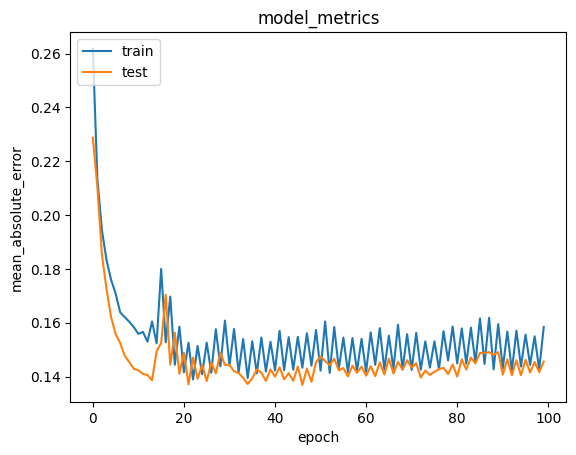

In [45]:
plt.plot(modelku.history['mean_absolute_error'])
plt.plot(modelku.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Getting top-N Recommendations

In [59]:
anime_df = anime_final

# get sample user
user_id = rating.user_id.sample(1).iloc[0]
anime_watched_by_user = rating[rating.user_id == user_id]

anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [60]:
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

print(f"Showing recommendations for user: {user_id}")
print("=" * 40)

print("Anime with high ratings from user")
print("-" * 40)

top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
  print(f"{row.name} : {', '.join(row.genre)}")

print('-' * 40)
print("Top 10 anime recommendations")
print('-' * 40)

recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
  print(f"{row.name} : {', '.join(row.genre)}")

141/141 [==============================] - 0s 2ms/step
Showing recommendations for user: 618
Anime with high ratings from user
----------------------------------------
Mononoke Hime : Action, Adventure, Fantasy
Great Teacher Onizuka : Comedy, Drama, School, Shounen, Slice of Life
Bakuman. 3rd Season : Comedy, Drama, Romance, Shounen
Beck : Comedy, Drama, Music, Shounen, Slice of Life
Durarara!! : Action, Mystery, Supernatural
----------------------------------------
Top 10 anime recommendations
----------------------------------------
Rainbow: Nisha Rokubou no Shichinin : Drama, Historical, Seinen, Thriller
Ginga Eiyuu Densetsu Gaiden: Senoku no Hoshi, Senoku no Hikari : Action, Military, Sci-Fi, Space
Arabian Nights: Sindbad no Bouken (TV) : Adventure, Fantasy, Magic, Romance
Gakkou no Kaidan: Kubinashi Rider!! Shi no Noroi : Horror, Mystery, Supernatural
Mermaid Forest OVA : Drama, Fantasy, Horror, Mystery
Akame ga Kill! Recap : Action, Adventure, Fantasy
Di Gi Charat Christmas Speci